# Gmsh examples

## Mobius strip

### Plot by Matplotlib

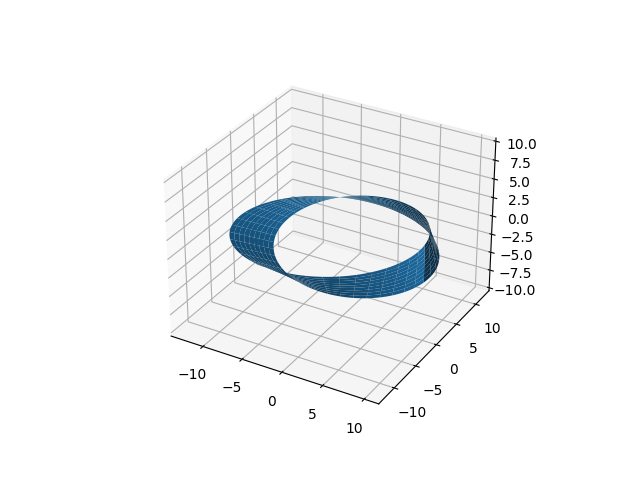

In [6]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt

# for interactive figures
%matplotlib widget

R = 10
W = 5

_u = np.linspace(0, 2*np.pi, 201, endpoint=True)
_v = np.linspace(-1/2, 1/2, 10)
u, v = np.meshgrid(_u, _v)

r = R - W*v*np.sin(u/2)
x = r*np.cos(u)
y = r*np.sin(u)
z = W*v*np.cos(u/2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z)
zlim = ax.set_zlim([-2*W, 2*W])

### Python script

In [2]:
import sys
import gmsh
import numpy as np

gmsh.initialize()
fac = gmsh.model.geo
R = 5
W = 2
M = 50
_u = np.linspace(0, 2*np.pi, M+1, endpoint=True)
_v = np.linspace(-1/2, 1/2, 2)
u, v = np.meshgrid(_u, _v)

r = R - W*v*np.sin(u/2)
x = r*np.cos(u)
y = r*np.sin(u)
z = W*v*np.cos(u/2)

points = [[], []]

line_current = None
ss = []
for i in range(M):
    points[0].append(fac.add_point(x[0, i], y[0, i], z[0, i]))
    points[1].append(fac.add_point(x[1, i], y[1, i], z[1, i]))
    line_pre = line_current
    line_current = fac.add_line(points[0][-1], points[1][-1])
    
    if i == 0:
        line0 = line_current
    else:
        j = i - 1
        line3 = fac.add_line(points[0][i-1], points[0][i])
        line4 = fac.add_line(points[1][i-1], points[1][i])


        cl = fac.add_curve_loop([line_pre, line4, -line_current, -line3])
        ss.append(fac.add_plane_surface([cl]))

line3 = fac.add_line(points[0][-1], points[1][0])
line4 = fac.add_line(points[1][-1], points[0][0])
cl = fac.add_curve_loop([line_current, line4, line0, -line3])
ss.append(fac.add_plane_surface([cl]))

fac.add_surface_loop(ss)
fac.synchronize()

h = 0.4
gmsh.option.setNumber("Mesh.MeshSizeMin", h)
gmsh.option.setNumber("Mesh.MeshSizeMax", h)

__old_verbosity = gmsh.option.getNumber("General.Verbosity")
gmsh.option.setNumber("General.Verbosity", 1)
# TODO: catch the exception of gmsh
gmsh.model.mesh.generate()
gmsh.option.setNumber("General.Verbosity", __old_verbosity)

gmsh.write('mobius.msh') 

# gui or not
if '-popup' in sys.argv:
    gmsh.fltk.run()


gmsh.finalize()

Info    : Writing 'mobius.msh'...
Info    : Done writing 'mobius.msh'


### Solve Possion problem on Mobius strip

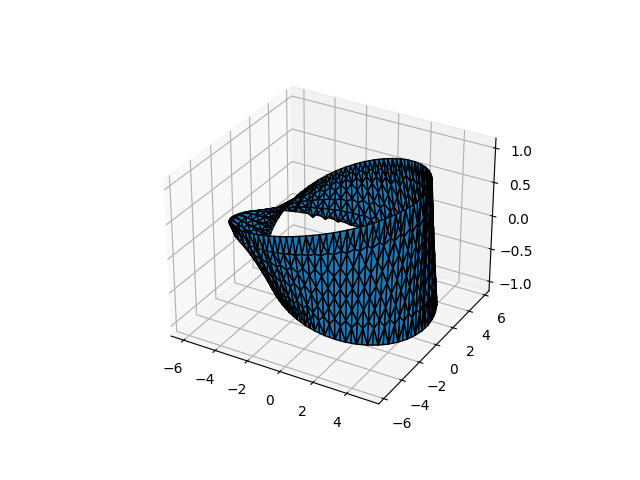

In [3]:
from firedrake import *

msh = Mesh('mobius.msh', dim=3)
triplot(msh)

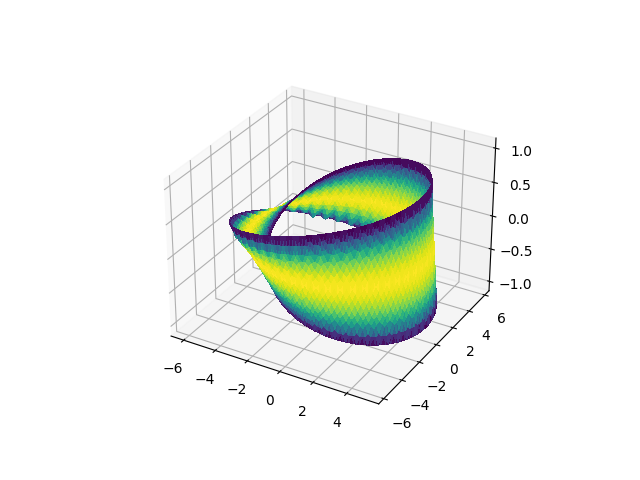

In [4]:
x, y, z = SpatialCoordinate(msh)
f = x**2 + y**2 + z**2

V = FunctionSpace(msh, 'CG', 1)
u, v = TrialFunction(V), TestFunction(V)
a = inner(grad(u), grad(v))*dx - inner(f, v)*dx

u = Function(V)
bc = DirichletBC(V, 0, 'on_boundary')
solve(lhs(a) == rhs(a), u, bcs=bc)

trisurf(u)

## Extrude for pml

### 3D

In [2]:
import sys
import gmsh
import numpy as np

gmsh.initialize()
sphere = gmsh.model.occ.add_sphere(0, 0, 0, 0.5, angle1=0)
gmsh.model.occ.synchronize()
bdy = gmsh.model.get_boundary([[3, sphere]])
plane = []
for dim, tag in bdy:
    name = gmsh.model.get_type(dim, abs(tag))
    if name == 'Sphere':
        inner_bdy = tag
    elif name == 'Plane':
        plane.append(abs(tag))
        
# heights = [0.1 for _ in range(8)]
# change recombine to True to get mix-cell mesh
top = gmsh.model.geo.extrude_boundary_layer([[2, inner_bdy]], numElements=[2], heights=[0.1], recombine=False)

gmsh.model.geo.synchronize()

gmsh.model.add_physical_group(2, plane, tag=1)
gmsh.model.set_physical_name(2, 1, "plane")
gmsh.model.add_physical_group(2, [inner_bdy], tag=2)
gmsh.model.set_physical_name(2, 2, "inner bdy")

gmsh.model.add_physical_group(2, [top[3][1]], tag=3)
gmsh.model.set_physical_name(2, 3, "plane2")
gmsh.model.add_physical_group(2, [top[0][1]], tag=4)
gmsh.model.set_physical_name(2, 4, "outer bdy")

gmsh.model.add_physical_group(3, [sphere], tag=1)
gmsh.model.set_physical_name(3, 1, "Domain")
gmsh.model.add_physical_group(3, [top[1][1]], tag=2)
gmsh.model.set_physical_name(3, 2, "PML")

gmsh.model.geo.synchronize()
# for dim, tag in top:
#     name = gmsh.model.get_type(dim, abs(tag))
#     print(name, dim, tag)
    
# gmsh.fltk.run()

gmsh.model.mesh.generate()

gmsh.write('gmsh/sphere_pml.msh')

Info    : Skipping boundary layer extrusion of degenerate curve 1


### 2D

In [7]:
import sys
import gmsh
import numpy as np

gmsh.initialize()
disk = gmsh.model.occ.add_disk(0, 0, 0, 0.5, 0.5)

gmsh.model.occ.synchronize()
bdy = gmsh.model.get_boundary([[2, disk]])

inner_bdy = bdy[0][1]

       
# heights = [0.1 for _ in range(8)]
# change recombine to True to get mix-cell mesh
top = gmsh.model.geo.extrude_boundary_layer([[1, inner_bdy]], numElements=[2], heights=[0.1], recombine=False)

gmsh.model.geo.synchronize()

gmsh.model.add_physical_group(1, [inner_bdy], tag=1)
gmsh.model.set_physical_name(1, 1, "inner bdy")

gmsh.model.add_physical_group(1, [top[0][1]], tag=2)
gmsh.model.set_physical_name(1, 2, "outer bdy")

gmsh.model.add_physical_group(2, [disk], tag=1)
gmsh.model.set_physical_name(2, 1, "Domain")
gmsh.model.add_physical_group(2, [top[1][1]], tag=2)
gmsh.model.set_physical_name(2, 2, "PML")

gmsh.model.geo.synchronize()
# for dim, tag in top:
#     name = gmsh.model.get_type(dim, abs(tag))
#     print(name, dim, tag)
    
# gmsh.fltk.run()

gmsh.model.mesh.generate()

gmsh.write('gmsh/disk_pml.msh')

#### Plot domain marker in space HDivT

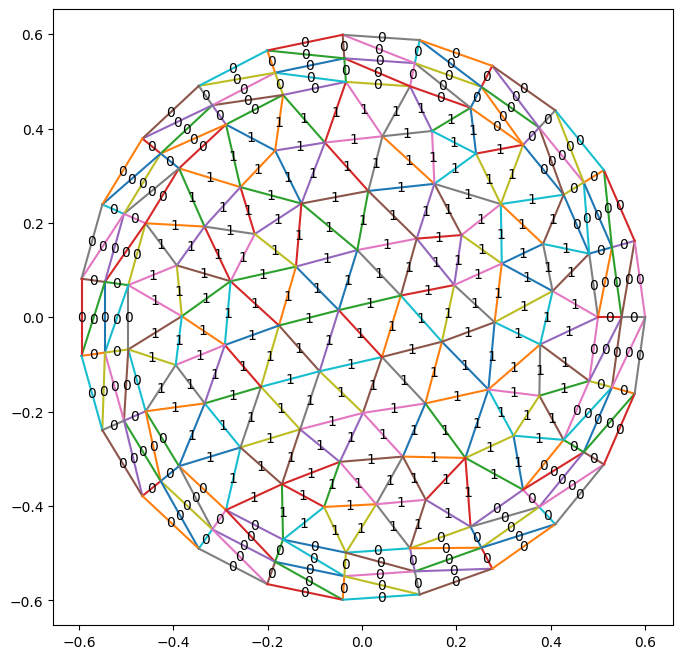

In [11]:
from firedrake import *
import numpy as np

mesh = Mesh('gmsh/disk_pml.msh')
V = FunctionSpace(mesh, 'HDivT', 1)


marker = Function(V, name='f')
par_loop(('{[i] : 0 <= i < f.dofs}', 'f[i, 0] = 1/2'),
         dx(1), {'f': (marker, INC)}, is_loopy_kernel=True)

index = marker.dat.data_with_halos < 3/4
marker.dat.data_with_halos[index] = 0

plex = mesh.topology_dm

s, e = plex.getHeightStratum(1)

coords = mesh.coordinates
csec = coords.function_space().dm.getSection()
sec = V.dm.getSection()

import matplotlib.pyplot as plt

plt.figure(figsize=[8, 8])
for i in range(s, e):
    a, b = plex.getCone(i)

    off_a = csec.getOffset(a)
    off_b = csec.getOffset(b)
    x1, y1 = coords.dat.data_ro_with_halos[off_a].real
    x2, y2 = coords.dat.data_ro_with_halos[off_b].real
    plt.plot([x1, x2], [y1, y2])
    off_i = sec.getOffset(i)
    v = marker.dat.data_ro_with_halos[off_i].real
    plt.text((x1 + x2)/2, (y1 + y2)/2, round(v), ha='center', va='center')

plt.axis('equal')

rank, size = mesh.comm.rank, mesh.comm.size
plt.savefig(f'hdivt-marker-{size}-{rank}.pdf')

# Gmsh Simplex Ordering

In [2]:
import numpy as np

def SN1(p):
    return p + 1

def SN2(p):
    return SN1(p) * SN1(p + 1) // 2
    
def SN3(p): 
    return SN2(p) * SN1(p + 2) // 3
    
def SI1(p, i):
    return i

def SI2(p, i, j): 
    return i + (SN2(p) - SN2(p - j))

def SI3(p, i, j, k):
    return SI2(p - k, i, j) + SN3(p) - SN3(p - k)

def SL1(p):
    for i in range(1, p):
        yield i

def SL2(p):
    for i in range(1, p - 1):
        for j in range(1, p - i):
            yield i, j

def SL3(p):
    for i in range(1, p - 2):
        for j in range(1, p - i):
            for k in range(1, p - i - j):
                yield i, j, k

def GmshLexOrder_SEG(p, node=0):
    index = lambda i: SI1(p, i)

    lex = - np.ones(SN1(p))
    
    if p == 0:
        lex[0] = node; node += 1
        return lex, node
    
    lex[index(0)] = node; node += 1
    lex[index(p)] = node; node += 1
    if p == 1:
        return lex, node
    
    for i in SL1(p):
        lex[index(i)] = node; node += 1
        
    return lex, node

def GmshLexOrder_TRI(p, node=0):
    index = lambda i, j: SI2(p, i, j)
    
    lex = - np.ones(SN2(p))
    
    if p == 0:
        lex[0] = node; node += 1
        return lex, node
    
    lex[index(0, 0)] = node; node += 1
    lex[index(p, 0)] = node; node += 1
    lex[index(0, p)] = node; node += 1
    
    if p == 1:
        return lex, node

    for i in SL1(p):
        lex[index(i, 0)]     = node; node += 1
    for j in SL1(p):
        lex[index(p - j, j)] = node; node += 1
    for j in SL1(p):
        lex[index(0, p - j)] = node; node += 1

    if p == 2:
        return lex, node
    
    sub, node = GmshLexOrder_TRI(p - 3, node);
    for _, (j, i) in enumerate(SL2(p)):
        lex[index(i, j)] = sub[_];

    return lex, node

def GmshLexOrder_TET(p, node=0):
    index = lambda i, j, k: SI3(p, i, j, k)
    lex = - np.ones(SN3(p))
    
    if p == 0:
        lex[0] = node; node += 1
        return lex, node
    lex[index(0, 0, 0)] = node; node += 1
    lex[index(p, 0, 0)] = node; node += 1
    lex[index(0, p, 0)] = node; node += 1
    lex[index(0, 0, p)] = node; node += 1
    
    if p == 1:
        return lex, node
    
    # internal edge nodes 
    for i in SL1(p): lex[index(    i,     0,     0)] = node; node += 1
    for j in SL1(p): lex[index(p - j,     j,     0)] = node; node += 1
    for j in SL1(p): lex[index(    0, p - j,     0)] = node; node += 1
    for k in SL1(p): lex[index(    0,     0, p - k)] = node; node += 1
    for j in SL1(p): lex[index(    0,     j, p - j)] = node; node += 1
    for i in SL1(p): lex[index(    i,     0, p - i)] = node; node += 1
    
    if p == 2:
        return lex, node
    
    # /* internal face nodes */
    sub, node = GmshLexOrder_TRI(p - 3, node)
    for _, (i, j) in enumerate(SL2(p)): 
        lex[index(i, j, 0)] = sub[_]
        
    sub, node = GmshLexOrder_TRI(p - 3, node);
    for _, (k, i) in enumerate(SL2(p)): 
        lex[index(i, 0, k)] = sub[_]
        
    sub, node = GmshLexOrder_TRI(p - 3, node);
    for _, (j, k) in enumerate(SL2(p)): 
        lex[index(0, j, k)] = sub[_]
        
    sub, node = GmshLexOrder_TRI(p - 3, node);
    for _, (j, i) in enumerate(SL2(p)): 
        lex[index(i, j, p - i - j)] = sub[_]
        
    if p == 3: 
        return lex, node

    # internal cell nodes */
    sub, node = GmshLexOrder_TET(p - 4, node);
    for _, (k, j, i) in enumerate(SL3(p)):
        lex[index(i, j, k)] = sub[_];

    return lex, node